# Iteration

This notebook is intended to provide a introduction to the idea of iteration as a tool for addressing problems in physics and engineering that have no simple analytic or closed form solution. Almost every significant computational problem I have addressed in my learning has involved some form of an iterative model. 

There are a lot of descriptions of iteration as a computational technique out there but this [mathematical definition](https://www2.edc.org/makingmath/mathtools/iteration/iteration.asp) fits best with my experience. The previous link has some lovely examples from mathematics including the Mandlebrot set.

<blockquote> Iteration is the repeated application of a function or process in which the output of each step is used as the input for the next iteration. </blockquote>



## Projectile Motion: Ideal Functions

As an example I will use basic projectile motion which we have a fairly comfortable understanding of it's ideal characteristics and some ways in which air drag (which requires an iterative analysis) affects the trajectory.

In the case of ideal projectile motion we have no air drag which leads to no acceleration in the x direction and $-10 \frac{m}{s^2}$ in the y direction. 

$$ x(t) = x_0 + v_{0_x} \cdot t$$
and 
$$ y(t) = y_0 + v_{0_y}\cdot t + \frac{1}{2} a_y \cdot t^2 $$

Taking components of the inital velocity as $v_{0_x} = v_0 cos(\theta)$ and $v_{0_y} = v_0 sin(\theta)$ which leads to 

$$ x(t) = x_0 + v_0 cos(\theta) \cdot t$$
and 
$$ y(t) = y_0 + v_0 sin(\theta) \cdot t + \frac{1}{2} a_y \cdot t^2 $$

If we know the initial velocity and the angle we have a well defined function that describes both x(t) and y(t). Here's how that analytic solution can be presented in a notebook.


In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Initial Conditions and Constants



In [131]:
# initial conditions
initialVelocity = 30.0 # in m/s
launchAngleDeg = 32. # in degrees
launchAngRad = launchAngleDeg*np.pi/180.
initialXposition = 0.0 # in m
initialYposition = 3.1 # in m

# constants
gravity = -9.81 # m/s/s
maxtime = 5.   # maximum time for model in s
numpoints = 100 # number of points on plot to calculate - an integer!

# determine components of the initial velocity
initialXvel = initialVelocity*np.cos(launchAngRad)
initialYvel = initialVelocity*np.sin(launchAngRad)

print("Launch Velocity: %.2f m/s; Vx: %.2f m/s Vy: %.2f m/s" % (initialVelocity,initialXvel,initialYvel))
print("Launch Angle: %.2f degrees" % launchAngleDeg)
print("Launch Location x: %.2f m y: %.2f m" % (initialXposition, initialYposition))

Launch Velocity: 30.00 m/s; Vx: 25.44 m/s Vy: 15.90 m/s
Launch Angle: 32.00 degrees
Launch Location x: 0.00 m y: 3.10 m


## Calculate x(t) and y(t):

First create a set of times that we will use to calculate the x and y positions using the [np.linspace](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html) function. Then apply the equations stated above. Because the time is in an array to square each time in the array I need the [np.square](https://numpy.org/doc/stable/reference/generated/numpy.square.html) function to be sure it squares each term not some other vector squaring operation. Turns out (I tried it) that np.square(modeltime) = modeltime\* modeltime so I didn't need to worry. 

In [132]:
modeltime = np.linspace(0.,maxtime,numpoints)
xposition = initialXposition + initialXvel*modeltime
yposition = initialYposition + initialYvel*modeltime + 0.5*gravity*np.square(modeltime)


## Plot

Now we plot it....

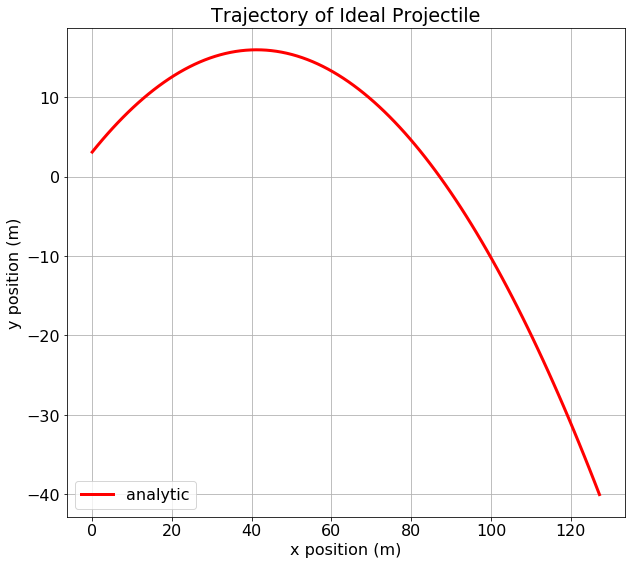

In [133]:
fig1, ax1 = plt.subplots()
ax1.plot(xposition, yposition,
         color = 'red', linestyle = '-',
         linewidth = 3., label = "analytic")


plt.rcParams.update({'font.size': 16}) # make labels easier to read
ax1.set(xlabel='x position (m)', ylabel='y position (m)',
       title='Trajectory of Ideal Projectile')

fig1.set_size_inches(10, 9)
ax1.grid()

plt.legend(loc= 3)
plt.show()

## What Something Changes Along the Way?

The previous solution to the problem doesn't work if any part of my solution changes in a complex way throughout the process. This next version of projectile motion I am going to take it one step at a time through the process which is what I will need to do when I have a more complex problem. For this next example I am not going to change any part of the problem I'm just going to get there by a more step by step process. At each point I'll calculate how far I go in each little dt of time and add it to my previous location. Very much like integrating by adding up rectangles or trapezoids.

### Important Note:

In this version of the projectile motion I am assuming that the velocity is constant over each iteration in time. I know that it is not but the underlying concept for iterative solutions is to assume that everything is constant so we are making a linear projection of the behavior. This assumption of constant velocity takes place in lines 37-40 roughly (unless I added lines of code after I wrote this comment) in the next cell.

### Set up arrays

When I did the previous calculation python assumed that because the modeltime was an array of some number of points that I wanted to create x(t) and y(t) and the same length of array and automatically filled in the values. In this case I don't know ahead of time where I am going to be at the 5th time point or nth time point so I need to create the arrays for the x(t) and y(t) myself. To do this I use the [np.full_like](https://numpy.org/doc/stable/reference/generated/numpy.full_like.html) function to create and array that has the same 'shape' as another array and fill in some placeholder values (I usually use 0. as I did in this case). After setting up the position arrays I need to set the first point to have the initial x and y values. This requires me to use and index to pick out a particular element in the array. 

The format for doing this is ```xpoints[0]``` is the first point in the array. ```xpoints[iterpoints]``` is the last point in the array.

Because velocity and acceleration might both be changing I need to also create arrays to track their behavior.

In [154]:
itertime = 5.0 # in s
iterpoints = 10 # number of points for iteration
iterationTime = np.linspace(0.,itertime,iterpoints)
deltaTime = iterationTime[1]-iterationTime[0] # determines the size of the delta t between points

# create the x(t) and y(t) arrays to be like iterationTime and fill with 0's
xPos = np.full_like(iterationTime,0)
yPos = np.full_like(iterationTime,0)
xVel = np.full_like(iterationTime,0)
yVel = np.full_like(iterationTime,0)
xAccel = np.full_like(iterationTime,0)
yAccel = np.full_like(iterationTime,0)


# set the first point of array to initial position
xPos[0] = initialXposition
yPos[0] = initialYposition
xVel[0] = initialXvel
yVel[0] = initialYvel
xAccel[0] = 0.
yAccel[0] = gravity

for i in range (1,iterpoints):
    # The X part
    # where the object will be and how fast is it going in the x direction after dt
    deltax = xVel[i-1]*deltaTime
    xPos[i] = xPos[i-1] + deltax
    # how fast will it be going after deltaTime - no change in this case
    xVel[i] = xVel[i-1]
    # what is it's acceleration after deltaTime - no change in this case
    xAccel[i]=xAccel[i-1]
    
    # The Y part
    # where the object will be and how fast is it going in the y direction after dt assuming cnst v
    deltay = yVel[i-1]*deltaTime
    yPos[i] = yPos[i-1] + deltay
    # how fast will it be going after deltaTime
    deltayVel = yAccel[i-1]*deltaTime
    yVel[i] = yVel[i-1]+deltayVel
    # what is it's acceleration after deltaTime - no change in this case
    yAccel[i]=yAccel[i-1]
    
## Print statements if needed to see what's happening for debugging
# print(yAccel)
# print(yPos)
# print(yVel)

## Plot It Again and NOTICE!

I have started this notebook with just a few iterations. If someone has 'turned up' the number of iterations above 10 put it back down to 10. Explain why the iterated data points go above the ideal trajectory of the projectile. Then, when you understand it, slowing increase the number of iterations to 100 or 1000. This is like doing integration with rectangles and slowly making the width of the rectangles smaller and smaller. This is a feature of iteration that you need to be aware of. Because we assume the velocity of the object is constant for the iteration time (deltaTime) there are inherent errors that will go away when we increase the number of iterations. It is however UNWISE to start with a large number of iterations until you are confident in your computational model.

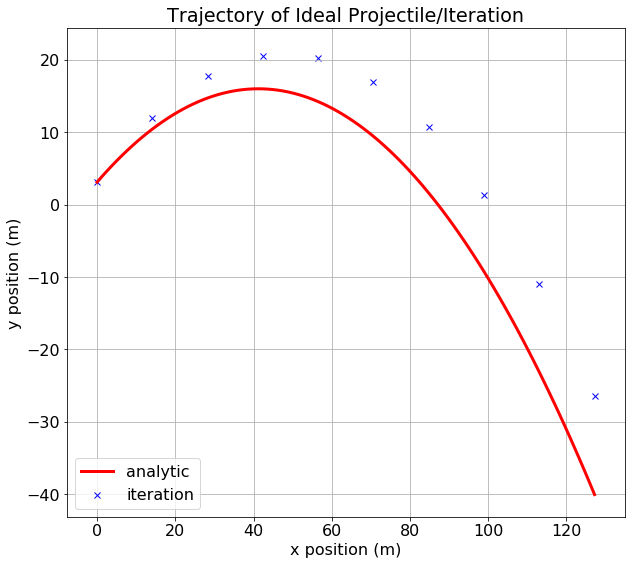

In [155]:
fig2, ax2 = plt.subplots()
ax2.plot(xposition, yposition,
         color = 'red', linestyle = '-',
         linewidth = 3., label = "analytic")
ax2.scatter(xPos, yPos,
         color = 'blue', marker = 'x',
         linewidth = 1., label = "iteration")


plt.rcParams.update({'font.size': 16}) # make labels easier to read
ax2.set(xlabel='x position (m)', ylabel='y position (m)',
       title='Trajectory of Ideal Projectile/Iteration')

fig2.set_size_inches(10, 9)
ax2.grid()

plt.legend(loc= 3)
plt.show()

## Now to Add Excitement!

So what if the y acceleration of this object depended on the height above the ground. It doesn't but we can imagine that if the units were km and the earth was a smaller planet then it might make sense. Let's imagine that the acceleration of gravity decreases by 1% for every m away from the ground. Nothing happens to the x part of the problem. Here's how I implemented this idea. 

```yPosE[i]-yPosE[0])``` is the number of meters above the starting point.

```yPosE[i]-yPosE[0])/100.``` is 1% if the object is 1 m above the starting point.

```deltaGravity = -gravity*(yPosE[i]-yPosE[0])/100.)``` This gives the change in the 'gravity' which will be positive when the object is above the starting point and negative when it is below the starting point. This is an important step and allows me to test my code in an interesting way. If I change the 100 to 1000 then gravity only changes by 0.1% for each m. If I make the 100 a 100000 then the new model should behave like the old model which helps me understand whether I wrote the code correctly.

```yAccelE[i]=gravity + deltaGravity``` adjusts the 'gravity' for the next step.

Before we worry about how to do this think about what you expect to happen. Will it go higher? ...further? Sometimes one doesn't know but it's always worth thinking about.

## Because Notebooks Remember Everything:

From an implementation perspective I am being careful to change the names of many of my arrays as I create each example. Remember that the notebook remembers what I've done before and I want to be able to compare each of my examples in my plots. This means I need arrays with different names.

## Things That Happen:

You will notice a number of print statements buried in various parts of the code. This happened because when I first wrote this up and plotted it the second and third plots looked exactly the same and I knew that wasn't right but I couldn't figure out where my mistake was. Eventually, using the print statements, I discovered I had forgotten to rename one variable and it was screwing up the whole calculation. This is what happens and it teaches us to test our code before relying on it.



In [156]:
# I'm going to keep the same iteration times etc so the new data points will correlate
# with the previously calculated data point.

# create the x(t) and y(t) arrays to be like iterationTime and fill with 0's
# the E tag at the end is for Excitement
xPosE = np.full_like(iterationTime,0)
yPosE = np.full_like(iterationTime,0)
xVelE = np.full_like(iterationTime,0)
yVelE = np.full_like(iterationTime,0)
xAccelE = np.full_like(iterationTime,0)
yAccelE = np.full_like(iterationTime,0)


# set the first point of array to initial position
xPosE[0] = initialXposition
yPosE[0] = initialYposition
xVelE[0] = initialXvel
yVelE[0] = initialYvel
xAccelE[0] = 0.
yAccelE[0] = gravity

for i in range (1,iterpoints):
    # The X part
    # where will it be and how fast is it going in the x direction after dt
    deltaxE = xVelE[i-1]*deltaTime
    xPosE[i] = xPosE[i-1] + deltaxE
    # how fast will it be going after deltaTime - no change in this case
    xVelE[i] = xVelE[i-1]
    # what is it's acceleration after deltaTime - no change in this case
    xAccelE[i]=xAccelE[i-1]
    
    # The Y part
    # where will it be and how fast is it going in the y direction after dt assuming cnst v
    deltayE = yVelE[i-1]*deltaTime
    yPosE[i] = yPosE[i-1] + deltayE
    # how fast will it be going after deltaTime
    deltayVelE = yAccelE[i-1]*deltaTime
    yVelE[i] = yVelE[i-1]+deltayVelE
    # print(deltayVelE)
    # what is it's acceleration after deltaTime - 1% per m of difference from starting point. See previous cell.
    deltaGravity = -gravity*(yPosE[i]-yPosE[0])/100.
    yAccelE[i]=gravity + deltaGravity
    # print(deltaGravity)
    
## Print statements if needed to see what's happening for debugging
# print(yAccelE)
# print(yPosE)
# print(yVelE)

## Plot All of Them:

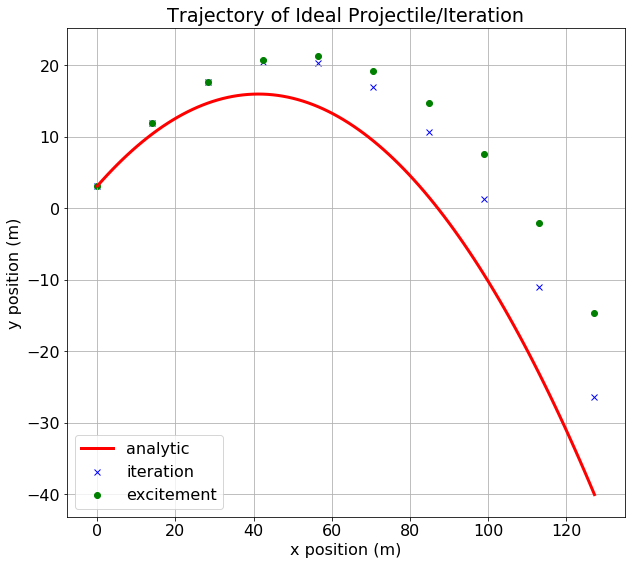

In [157]:
fig3, ax3 = plt.subplots()
ax3.plot(xposition, yposition,
         color = 'red', linestyle = '-',
         linewidth = 3., label = "analytic")
ax3.scatter(xPos, yPos,
         color = 'blue', marker = 'x',
         linewidth = 1., label = "iteration")
ax3.scatter(xPosE, yPosE,
         color = 'green', marker = 'o',
         linewidth = 1., label = "excitement")


plt.rcParams.update({'font.size': 16}) # make labels easier to read
ax3.set(xlabel='x position (m)', ylabel='y position (m)',
       title='Trajectory of Ideal Projectile/Iteration')

fig3.set_size_inches(10, 9)
ax3.grid()

plt.legend(loc= 3)
plt.show()